#### Description
This code uses distance to the nearest dam to calculate the targeting ratio between CPIS and Irrigated land. 

$$
\text{Targeting Ratio}_{(r = \text{distance range})} = \frac{\# \text{ of CPIS in } r}{\sum^{{countries}} ((\# \text{ of CPIS in country }) \times (\text{\% Irrigated Area in country in } r))}
$$


In [7]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from tqdm import tqdm
from scipy.spatial import cKDTree
import scipy.stats as stats
import numpy as np
import yaml
import os


# Load configuration
with open('../../config.yaml', 'r') as file:
    config = yaml.safe_load(file)

def resolve_path(relative_path):
    return os.path.join(config['base_path'], relative_path)

Generate the distance ranges

In [2]:
# Generate 10 intervals between 0 and 100,000
interval_edges = np.linspace(0, 100000, num=11)

# Create the distance ranges as tuples
distance_ranges = [(interval_edges[i], interval_edges[i+1]) for i in range(len(interval_edges)-1)]

print(distance_ranges)

[(0.0, 10000.0), (10000.0, 20000.0), (20000.0, 30000.0), (30000.0, 40000.0), (40000.0, 50000.0), (50000.0, 60000.0), (60000.0, 70000.0), (70000.0, 80000.0), (80000.0, 90000.0), (90000.0, 100000.0)]


Load the necessary files

In [3]:
# Load and reproject shp files
def load_and_reproject_shapefiles(layers, base_key, crs="EPSG:3857"):
    gdfs = {}
    for layer in layers:
        gdf = gpd.read_file(resolve_path(config[f'{base_key}_{layer}_shp_path']))
        gdf = gdf.to_crs(crs)
        gdfs[layer] = gdf
        print(gdf.head())
    return gdfs

# Layers to process
layers = ['All', 'Semi_Arid', 'Arid', 'Hyper_Arid']

# Load and reproject dam, AEI, and CPIS data
layer_dam_gdfs = load_and_reproject_shapefiles(layers, 'Africa_Dam')
layer_AEI_gdfs = load_and_reproject_shapefiles(layers, 'AEI_2015_by_Country')
layer_cpis_gdfs = load_and_reproject_shapefiles(layers, 'Combined_CPIS')


      Country                               Purpose  ISO  Long__res_  \
0    Zimbabwe                Hydropower, Irrigation  ZWE   32.016700   
1  Mozambique                Hydropower; Irrigation  MOZ   32.143353   
2     Morocco  Hydropower, Irrigation, Water Supply  MAR   -4.676228   
3       Egypt                            Irrigation  EGY   31.189583   
4     Algeria                            Irrigation  DZA    5.923963   

   Lat__res_  index_righ   FID                          geometry  
0 -19.250000        3566  3566  POINT (3564082.741 -2184391.590)  
1 -23.872949        3566  3566  POINT (3578181.688 -2737934.017)  
2  33.930336        2466  2466   POINT (-520555.320 4019451.684)  
3  27.202083        2466  2466   POINT (3472008.498 3148742.115)  
4  34.853860        2466  2466    POINT (659452.545 4144038.994)  
        Country                               Purpose  ISO  Long__res_  \
0      Zimbabwe                Hydropower, Irrigation  ZWE   32.016700   
1    Mozambique  

Sort CPIS by distance to nearest dam

In [4]:

# Calculate nearest dam for each CPIS
def calculate_distances(src_gdf, target_gdf):
    src_centroids = np.array(list(src_gdf.geometry.centroid.apply(lambda geom: (geom.x, geom.y))))
    target_points = np.array(list(target_gdf.geometry.apply(lambda geom: (geom.x, geom.y))))
    
    if len(target_points) == 0:
        return np.array([])  # Return empty array if no points
    
    tree = cKDTree(target_points)
    dists, _ = tree.query(src_centroids, k=1)
    
    return dists

# Calculate the nearest dam for each CPIS
nearest_dam_distances = {}

for layer in layers:
    gdf_cpis = layer_cpis_gdfs[layer]
    gdf_dams = layer_dam_gdfs[layer]
    distances = calculate_distances(gdf_cpis, gdf_dams)
    nearest_dam_distances[layer] = distances


# Classify CPIS into distance ranges
def classify_cpis_by_distance_ranges(distances, distance_ranges):
    classifications = {}
    for (lower_bound, upper_bound) in distance_ranges:
        classifications[f'{lower_bound}-{upper_bound}'] = np.where(
            (distances >= lower_bound) & (distances < upper_bound), 1, 0)
    return classifications

cpis_classifications = {}

for layer in layers:
    distances = nearest_dam_distances[layer]
    cpis_classifications[layer] = classify_cpis_by_distance_ranges(distances, distance_ranges)
    print(cpis_classifications[layer])

{'0.0-10000.0': array([0, 0, 0, ..., 0, 0, 0]), '10000.0-20000.0': array([0, 0, 0, ..., 0, 0, 0]), '20000.0-30000.0': array([1, 1, 1, ..., 0, 0, 0]), '30000.0-40000.0': array([0, 0, 0, ..., 0, 0, 0]), '40000.0-50000.0': array([0, 0, 0, ..., 0, 0, 0]), '50000.0-60000.0': array([0, 0, 0, ..., 0, 0, 0]), '60000.0-70000.0': array([0, 0, 0, ..., 0, 0, 0]), '70000.0-80000.0': array([0, 0, 0, ..., 0, 0, 0]), '80000.0-90000.0': array([0, 0, 0, ..., 0, 0, 0]), '90000.0-100000.0': array([0, 0, 0, ..., 0, 0, 0])}
{'0.0-10000.0': array([0, 0, 0, ..., 0, 0, 0]), '10000.0-20000.0': array([0, 0, 0, ..., 0, 0, 0]), '20000.0-30000.0': array([1, 1, 1, ..., 0, 0, 0]), '30000.0-40000.0': array([0, 0, 0, ..., 1, 1, 1]), '40000.0-50000.0': array([0, 0, 0, ..., 0, 0, 0]), '50000.0-60000.0': array([0, 0, 0, ..., 0, 0, 0]), '60000.0-70000.0': array([0, 0, 0, ..., 0, 0, 0]), '70000.0-80000.0': array([0, 0, 0, ..., 0, 0, 0]), '80000.0-90000.0': array([0, 0, 0, ..., 0, 0, 0]), '90000.0-100000.0': array([0, 0, 0, 

Find percentage of irrigated land within each range per country

In [5]:
def calculate_proportion_irrigated_pixels(layer_AEI_gdfs, layer_dam_gdfs, distance_ranges, layers):
    proportion_irrigated_pixels = {}

    for layer in layers:
        gdf_AEI = layer_AEI_gdfs[layer]
        gdf_dams = layer_dam_gdfs[layer]

        proportions_by_country_and_range = {}
        #print(gdf_AEI.columns)
        #print(gdf_dams.columns)

        for iso3 in gdf_AEI['ISO3'].unique():
            country_group = gdf_AEI[gdf_AEI['ISO3'] == iso3]
            dams_in_country = gdf_dams[gdf_dams['ISO'] == iso3]

            distances = calculate_distances(country_group, dams_in_country)

            proportions_by_range = {}
            total_pixels = len(country_group)

            for (lower_bound, upper_bound) in distance_ranges:
                within_range = np.sum((distances >= lower_bound) & (distances < upper_bound))
    
                if total_pixels == 0:
                    proportions_by_range[f'{lower_bound}-{upper_bound}'] = 0  # or skip this range
                    #print(f"Skipping range {lower_bound}-{upper_bound} due to total_pixels being 0")
                else:
                    proportions_by_range[f'{lower_bound}-{upper_bound}'] = within_range / total_pixels
                    # Debug print statement
                    #print(f"Country: {iso3}, Range {lower_bound}-{upper_bound}: {within_range} pixels within range, Total pixels: {total_pixels}")
            
            proportions_by_country_and_range[iso3] = proportions_by_range
            #print(iso3)
            #print(proportions_by_country_and_range[iso3])

        proportion_irrigated_pixels[layer] = proportions_by_country_and_range

    return proportion_irrigated_pixels

proportion_irrigated_pixels = calculate_proportion_irrigated_pixels(layer_AEI_gdfs, layer_dam_gdfs, distance_ranges, layers)
print(proportion_irrigated_pixels)

{'All': {'TUN': {'0.0-10000.0': 0.0, '10000.0-20000.0': 0.0, '20000.0-30000.0': 0.0, '30000.0-40000.0': 0.0, '40000.0-50000.0': 0.0, '50000.0-60000.0': 0.0, '60000.0-70000.0': 0.0, '70000.0-80000.0': 0.0, '80000.0-90000.0': 0.0, '90000.0-100000.0': 0.0}, 'DZA': {'0.0-10000.0': 0.03313452617627568, '10000.0-20000.0': 0.08018555334658714, '20000.0-30000.0': 0.1172962226640159, '30000.0-40000.0': 0.10801855533465872, '40000.0-50000.0': 0.09211398277004638, '50000.0-60000.0': 0.0828363154406892, '60000.0-70000.0': 0.06759443339960239, '70000.0-80000.0': 0.06560636182902585, '80000.0-90000.0': 0.0390987408880053, '90000.0-100000.0': 0.03711066931742876}, 'MAR': {'0.0-10000.0': 0.02557544757033248, '10000.0-20000.0': 0.059676044330775786, '20000.0-30000.0': 0.08269394714407502, '30000.0-40000.0': 0.10315430520034101, '40000.0-50000.0': 0.10741687979539642, '50000.0-60000.0': 0.10912190963341858, '60000.0-70000.0': 0.08951406649616368, '70000.0-80000.0': 0.0792838874680307, '80000.0-90000.0':

Calculate Targeting Ratio and confidence intervals

Processing layer: All
Processing range: 0.0-10000.0
Numerator: 1254
0 + 4 * 0.0 =
0.0
0.0 + 802 * 0.03313452617627568 =
26.573889993373093
26.573889993373093 + 150 * 0.02557544757033248 =
30.410207128922966
30.410207128922966 + 1519 * 0.007905138339920948 =
42.418112267262885
42.418112267262885 + 0 * 0 =
42.418112267262885
42.418112267262885 + 290 * 0.004032258064516129 =
43.587467105972564
43.587467105972564 + 36 * 0.0 =
43.587467105972564
43.587467105972564 + 14 * 0.005 =
43.657467105972565
43.657467105972565 + 0 * 0.010739856801909307 =
43.657467105972565
43.657467105972565 + 0 * 0.0 =
43.657467105972565
43.657467105972565 + 27 * 0.0032258064516129032 =
43.74456388016611
43.74456388016611 + 75 * 0.00851063829787234 =
44.382861752506535
44.382861752506535 + 0 * 0.0 =
44.382861752506535
44.382861752506535 + 35 * 0.0875 =
47.445361752506535
47.445361752506535 + 0 * 0.012048192771084338 =
47.445361752506535
47.445361752506535 + 1 * 0.030141843971631204 =
47.47550359647817
47.47550359647

/tmp/ipykernel_1369083/3622819293.py:110: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f'{int(float(label.get_text().split("-")[0]))/1000:.0f}-{int(float(label.get_text().split("-")[1])/1000)} km'


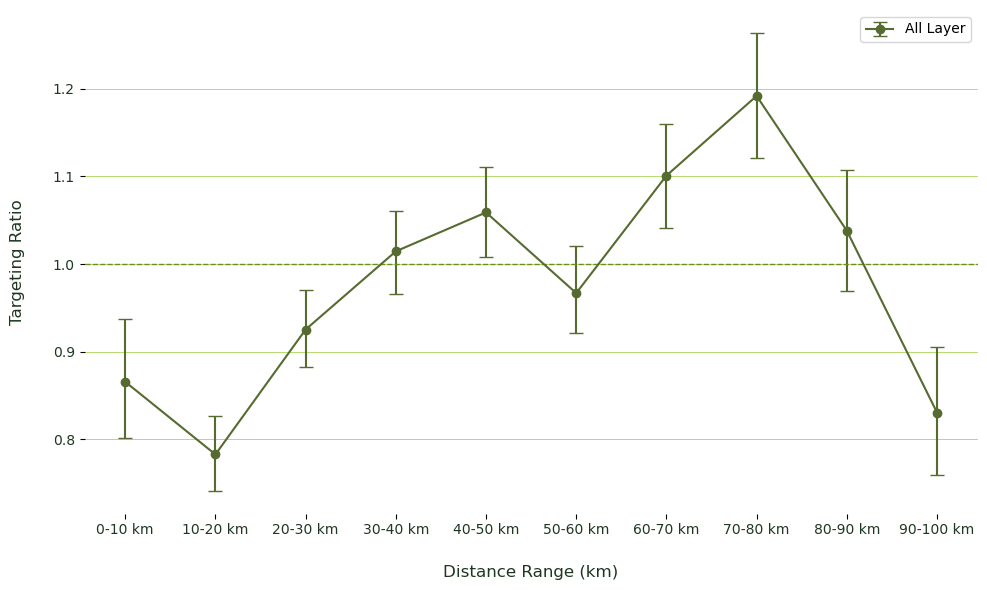

/tmp/ipykernel_1369083/3622819293.py:110: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f'{int(float(label.get_text().split("-")[0]))/1000:.0f}-{int(float(label.get_text().split("-")[1])/1000)} km'


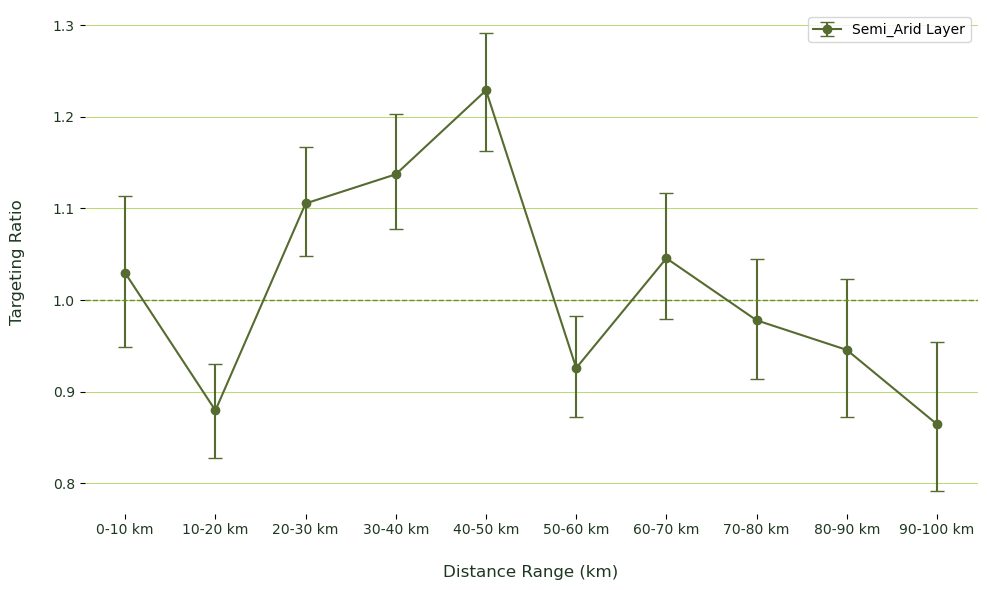

/tmp/ipykernel_1369083/3622819293.py:110: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f'{int(float(label.get_text().split("-")[0]))/1000:.0f}-{int(float(label.get_text().split("-")[1])/1000)} km'


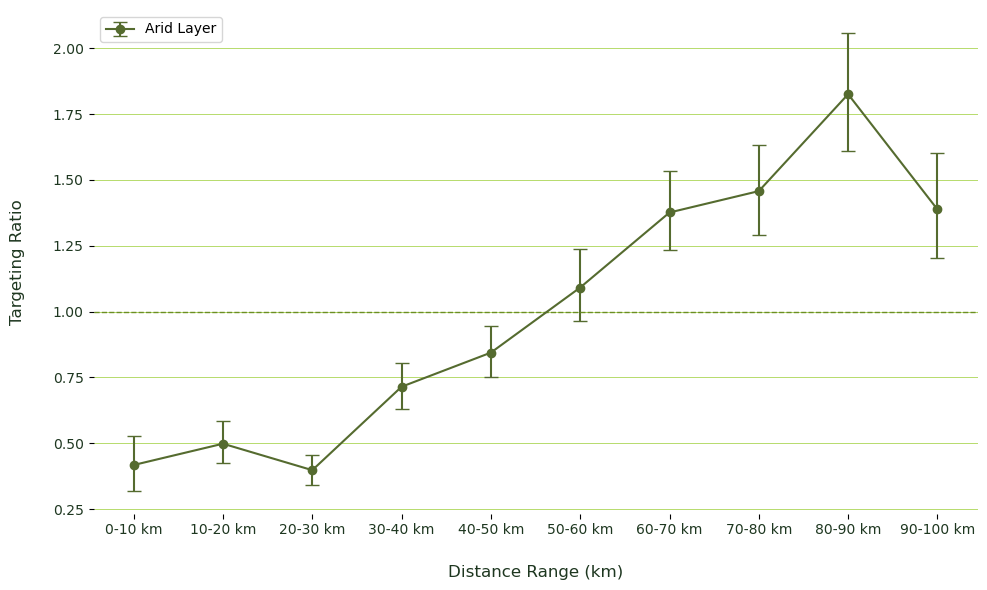

/tmp/ipykernel_1369083/3622819293.py:110: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f'{int(float(label.get_text().split("-")[0]))/1000:.0f}-{int(float(label.get_text().split("-")[1])/1000)} km'


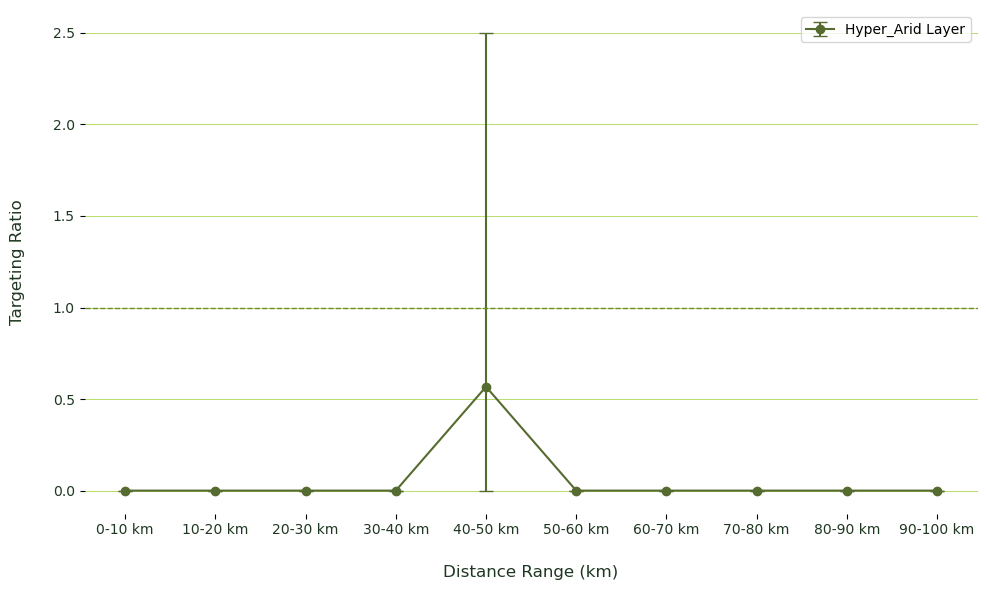

In [8]:
def bootstrap_targeting_ratio(numerator, denominator, num_bootstrap=10000):
    ratios = []
    for _ in range(num_bootstrap):
        boot_numerator = np.random.poisson(numerator)
        boot_denominator = np.random.poisson(denominator)
        if boot_denominator != 0:
            boot_ratio = boot_numerator / boot_denominator
        else:
            boot_ratio = np.nan
        ratios.append(boot_ratio)
    ratios = np.array(ratios)
    return np.nanpercentile(ratios, 2.5), np.nanpercentile(ratios, 97.5)

def calculate_targeting_ratios_with_bootstrap(cpis_classifications, proportion_irrigated_pixels, layers, num_bootstrap=1000):
    targeting_ratios_by_layer = {}
    confidence_intervals_by_layer = {}
    numerators_by_layer = {}
    denominators_by_layer = {}

    for layer in layers:
        print(f"Processing layer: {layer}")

        classifications = cpis_classifications.get(layer, {})
        proportions = proportion_irrigated_pixels.get(layer, {})

        targeting_ratios = {}
        confidence_intervals = {}
        numerators = {}
        denominators = {}

        for range_key in classifications.keys():
            print(f"Processing range: {range_key}")

            numerator = np.sum(classifications[range_key])
            print(f"Numerator: {numerator}")

            denominator = 0
            for iso3 in proportions.keys():
                if range_key in proportions[iso3]:
                    cpis_in_country = np.sum(layer_cpis_gdfs[layer]['ISO3'] == iso3)
                    percentage_in_range = proportions[iso3][range_key]
                    print(f'{denominator} + {cpis_in_country} * {percentage_in_range} =')
                    denominator += cpis_in_country * percentage_in_range
                    print(denominator)

            print(f"Denominator: {denominator}")

            targeting_ratio = numerator / denominator if denominator != 0 else np.nan

            # Bootstrap CI calculation
            if denominator != 0:
                ci_lower, ci_upper = bootstrap_targeting_ratio(numerator, denominator, num_bootstrap=num_bootstrap)
            else:
                ci_lower, ci_upper = np.nan, np.nan

            targeting_ratios[range_key] = targeting_ratio
            confidence_intervals[range_key] = (ci_lower, ci_upper)
            numerators[range_key] = numerator
            denominators[range_key] = denominator

        targeting_ratios_by_layer[layer] = targeting_ratios
        confidence_intervals_by_layer[layer] = confidence_intervals
        numerators_by_layer[layer] = numerators
        denominators_by_layer[layer] = denominators

        # Print the targeting ratios and CIs for the current layer
        print(f"Targeting Ratios for {layer} layer:")
        for range_key, ratio in targeting_ratios.items():
            ci = confidence_intervals[range_key]
            print(f"{range_key}: {ratio:.4f} (95% CI: {ci[0]:.4f}, {ci[1]:.4f})")

    return targeting_ratios_by_layer, confidence_intervals_by_layer, numerators_by_layer, denominators_by_layer



def plot_targeting_ratios_with_ci(targeting_ratios_by_layer, confidence_intervals_by_layer):
    fig_num = 0
    for layer, ratios in targeting_ratios_by_layer.items():
        ranges = list(ratios.keys())
        ratio_values = list(ratios.values())
        
        # Extracting the CIs
        ci_lower = [confidence_intervals_by_layer[layer][range_key][0] for range_key in ranges]
        ci_upper = [confidence_intervals_by_layer[layer][range_key][1] for range_key in ranges]
        
        # Midpoint for the error bars
        error = np.array([ratio_values - np.array(ci_lower), np.array(ci_upper) - ratio_values])

        plt.figure(figsize=(10, 6))
        ax = plt.gca()

        # Remove spines to get rid of the grid-like appearance and borders
        for spine in ax.spines.values():
            spine.set_visible(False)

        # Set the background to white
        ax.set_facecolor('white')
        plt.gcf().set_facecolor('white')

        plt.errorbar(ranges, ratio_values, yerr=error, fmt='-o', capsize=5, color='darkolivegreen', label=f'{layer} Layer')
        
        # Add horizontal line at 1
        plt.axhline(y=1, color='olivedrab', linestyle='--', linewidth=1)

        # Display only horizontal grid lines
        ax.grid(True, axis='y', linestyle='-', linewidth=0.5, color='yellowgreen')
        ax.grid(False, axis='x')  # Disable vertical grid lines

        # Convert x-axis labels from meters to kilometers
        ax.set_xticklabels([f'{int(float(label.get_text().split("-")[0]))/1000:.0f}-{int(float(label.get_text().split("-")[1])/1000)} km' 
                            if "-" in label.get_text() else label.get_text() 
                            for label in ax.get_xticklabels()])
        
        plt.xlabel('Distance Range (km)', fontsize=12, labelpad=20, color='#1E3720')
        plt.ylabel('Targeting Ratio', fontsize=12, labelpad=20, color='#1E3720')
        #plt.title(f'Targeting Ratios with 95% CI - {layer} Layer')
        plt.xticks(color='#1E3720')
        plt.yticks(color='#1E3720')
        plt.legend()
        plt.tight_layout()
        plt.savefig(resolve_path(config[f'3_Figure{fig_num}']))
        fig_num += 1
        plt.show()

# Call the function with your data
targeting_ratios_by_layer, confidence_intervals_by_layer, numerators_by_layer, denominators_by_layer = calculate_targeting_ratios_with_bootstrap(cpis_classifications, proportion_irrigated_pixels, layers)

# Plot the results
plot_targeting_ratios_with_ci(targeting_ratios_by_layer, confidence_intervals_by_layer)